In [36]:
import librosa
import math
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [37]:
class GenreFeature:

    hop_length = 0
    genre_list = [
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
    ]

    dir_trainfolder = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\_train"
    dir_validationfolder = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\_validation"
    dir_testfolder = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\_test"
    dir_all_files = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzann"

    train_x = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\data_train_input.npy"
    train_y = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\data_train_target.npy"
    validation_x = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\data_validation_input.npy"
    validation_y = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\data_validation_target.npy"
    test_x = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\data_test_input.npy"
    test_y = r"C:\Users\Theint Myat Wai\Desktop\music-genre-classification\LSTM\gtzan\data_test_target.npy"

    train_X = train_Y = None
    validation_X = validation_Y = None
    test_X = test_Y = None

    def __init__(self):
        self.hop_length = 512

        self.timeseries_length_list = []
        self.train_lst = self.audio_directory(self.dir_trainfolder)
        self.validation_lst = self.audio_directory(self.dir_validationfolder)
        self.test_lst = self.audio_directory(self.dir_testfolder)

        self.all_files_list = []
        self.all_files_list.extend(self.train_lst)
        self.all_files_list.extend(self.validation_lst)
        self.all_files_list.extend(self.test_lst)


        self.timeseries_length = (128)   
        

    def load_preprocess_data(self):
        self.train_X, self.train_Y = self.extract_audio_features(self.train_lst)
        with open(self.train_x, "wb") as f:
            np.save(f, self.train_X)
        with open(self.train_y, "wb") as f:
            self.train_Y = self.one_hot(self.train_Y)
            np.save(f, self.train_Y)

        self.validation_X, self.validation_Y = self.extract_audio_features(self.validation_lst)
        with open(self.validation_x, "wb") as f:
            np.save(f, self.validation_X)
        with open(self.validation_y, "wb") as f:
            self.validation_Y = self.one_hot(self.validation_Y)
            np.save(f, self.validation_Y)

        self.test_X, self.test_Y = self.extract_audio_features(self.test_lst)
        with open(self.test_x, "wb") as f:
            np.save(f, self.test_X)
        with open(self.test_y, "wb") as f:
            self.test_Y = self.one_hot(self.test_Y)
            np.save(f, self.test_Y)

    def load_deserialize_data(self):
        self.train_X = np.load(self.train_x)
        self.train_Y = np.load(self.train_y)

        self.validation_X = np.load(self.validation_x)
        self.validation_Y = np.load(self.validation_y)

        self.test_X = np.load(self.test_x)
        self.test_Y = np.load(self.test_y)

    def precompute_min_timeseries_len(self):
        for file in self.all_files_list:
            y, sr = librosa.load(file)
            self.timeseries_length_list.append(math.ceil(len(y) / self.hop_length))
    #helper function to extract chroma, spectral and mfcc features
    def extract_audio_features(self, audio_lst):
        target = []
        data = np.zeros(
            (len(audio_lst), self.timeseries_length, 33), dtype=np.float64
        )
        
        for i, file in enumerate(audio_lst):
            y, sr = librosa.load(file)
            #extract chroma
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=self.hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=self.hop_length
            )
            #extract spectral
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=self.hop_length
            )
            #extract mfcc
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=self.hop_length, n_mfcc=13
            )
            #data cleaning
            splits = re.split("[ .]", file)
            genre = re.split("[ /]", splits[1])[3]
            target.append(genre)

            data[i, :, 0:13] = mfcc.T[0:self.timeseries_length, :]
            data[i, :, 13:14] = spectral_center.T[0:self.timeseries_length, :]
            data[i, :, 14:26] = chroma.T[0:self.timeseries_length, :]
            data[i, :, 26:33] = spectral_contrast.T[0:self.timeseries_length, :]

        return data, np.expand_dims(np.asarray(target), axis=1)

    def one_hot(self, Y_genre_strings):
        y_one_hot = np.zeros((Y_genre_strings.shape[0], len(self.genre_list)))
        for i, genre_string in enumerate(Y_genre_strings):
            index = self.genre_list.index(genre_string)
            y_one_hot[i, index] = 1
        return y_one_hot
    #returns the audio directory list
    def audio_directory(self, dir_folder):
        audio_lst = []
        for file in os.listdir(dir_folder):
            if file.endswith(".au"):
                directory = "%s/%s" % (dir_folder, file)
                audio_lst.append(directory)
        return audio_lst

In [38]:
#LSTM inputs : spectral {centroid, contrast}, chromagram & MFCC features (33 total values)
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=8):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        #lstm layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, num_layers = 2)
        #fully connected layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input, hidden=None):
        lstm_out, hidden = self.lstm(input, hidden)
        #output of the last step of the sequence
        logits = self.fc(lstm_out[-1])              
        pred = F.log_softmax(logits, dim=1)
        return pred, hidden

    def get_accuracy(self, logits, target):
        corrects = (
                torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum() 
        accuracy = (corrects *100) / self.batch_size
        return accuracy.item()

In [39]:

genre_features = GenreFeature()

# if all of the preprocessed files do not exist, regenerate them all for self-consistency
if (
os.path.isfile(genre_features.train_x)
and os.path.isfile(genre_features.train_y)
and os.path.isfile(genre_features.validation_x)
and os.path.isfile(genre_features.validation_y)
and os.path.isfile(genre_features.test_x)
and os.path.isfile(genre_features.test_y)
):
    print("Preprocessed files exist, deserializing npy files")
    genre_features.load_deserialize_data()
else:
    print("Preprocessing raw audio files")
    genre_features.load_preprocess_data()

batch_size = 10
#training the model
print("Build simple LSTM model ...")
model = LSTM(
    input_dim=33, hidden_dim=128, batch_size=batch_size, output_dim=8)

#parameters definition
loss_function = nn.NLLLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50




#to remember the lstm state
curr_state = False
# all training data (epoch) / batch_size == num_batches (12)
num_batches = int(genre_features.train_X.shape[0] / batch_size)
num_batches_val = int(genre_features.validation_X.shape[0] / batch_size)

val_loss_list, val_accuracy_list, epoch_list = [], [], []
training_losses = []
training_acc = []

#data_preprocessing

train_X = torch.from_numpy(genre_features.train_X).type(torch.Tensor)
validation_X = torch.from_numpy(genre_features.validation_X).type(torch.Tensor)
test_X = torch.from_numpy(genre_features.test_X).type(torch.Tensor)

train_Y = torch.from_numpy(genre_features.train_Y).type(torch.LongTensor)
validation_Y = torch.from_numpy(genre_features.validation_Y).type(torch.LongTensor)
test_Y = torch.from_numpy(genre_features.test_Y).type(torch.LongTensor)


for epoch in range(num_epochs):

    training_loss, training_accuracy = 0.0, 0.0
    hidden_state = None
    for i in range(num_batches):
        model.zero_grad()

        X_minibatch, y_minibatch = (
            train_X[i * batch_size: (i + 1) * batch_size, ],
            train_Y[i * batch_size: (i + 1) * batch_size, ],
        )

        # Reshape : seq length, batch_size, input_size)
        X_minibatch = X_minibatch.permute(1, 0, 2)
        y_minibatch = torch.max(y_minibatch, 1)[1]
        #forward pass
        y_pred, hidden_state = model(X_minibatch, hidden_state)  

        if not curr_state:
            hidden_state = None
        else:
            h_0, c_0 = hidden_state
            h_0.detach_()
            c_0.detach_()
            hidden_state = (h_0, c_0)

        loss = loss_function(y_pred, y_minibatch) 
        loss.backward()  
        optimizer.step() 

        training_loss += loss.detach().item()  
        training_accuracy += model.get_accuracy(y_pred, y_minibatch)

    training_losses.append(training_loss/ num_batches)
    training_acc.append(training_accuracy/ num_batches)

    print(
        "Epoch:  %d | Loss: %.4f | Training Accuracy: %.2f"
        % (epoch, training_loss / num_batches, training_accuracy / num_batches)
    )

    
    #validation
    val_running_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        model.eval()

        hidden_state = None
        for i in range(num_batches_val):
            #minibatch
            X_validation_minibatch, y_validation_minibatch = (
                validation_X[i * batch_size: (i + 1) * batch_size, ],
                validation_Y[i * batch_size: (i + 1) * batch_size, ],
            )
            X_minibatch = X_validation_minibatch.permute(1, 0, 2)
            y_minibatch = torch.max(y_validation_minibatch, 1)[1]

            y_pred, hidden_state = model(X_minibatch, hidden_state)
            if not curr_state:
                hidden_state = None
            #calculate loss
            val_loss = loss_function(y_pred, y_minibatch)

            val_running_loss += (
                val_loss.detach().item()
            )  
            val_acc += model.get_accuracy(y_pred, y_minibatch)

        model.train() 
        print(
            "Epoch:  %d | NLLoss: %.4f | Train Accuracy: %.2f | Val Loss %.4f  | Val Accuracy: %.2f"
            % (
                epoch,
                training_loss / num_batches,
                training_accuracy / num_batches,
                val_running_loss / num_batches_val,
                val_acc / num_batches_val,
            )
        )

    epoch_list.append(epoch)
    val_accuracy_list.append(val_acc / num_batches_val)
    val_loss_list.append(val_running_loss / num_batches_val)

Preprocessed files exist, deserializing npy files
Build simple LSTM model ...
Epoch:  0 | Loss: 1.9133 | Training Accuracy: 20.71
Epoch:  0 | NLLoss: 1.9133 | Train Accuracy: 20.71 | Val Loss 1.6248  | Val Accuracy: 33.33
Epoch:  1 | Loss: 1.5605 | Training Accuracy: 31.43
Epoch:  1 | NLLoss: 1.5605 | Train Accuracy: 31.43 | Val Loss 1.3289  | Val Accuracy: 47.50
Epoch:  2 | Loss: 1.5345 | Training Accuracy: 30.24
Epoch:  2 | NLLoss: 1.5345 | Train Accuracy: 30.24 | Val Loss 1.4148  | Val Accuracy: 45.83
Epoch:  3 | Loss: 1.4234 | Training Accuracy: 38.81
Epoch:  3 | NLLoss: 1.4234 | Train Accuracy: 38.81 | Val Loss 1.3938  | Val Accuracy: 45.00
Epoch:  4 | Loss: 1.3675 | Training Accuracy: 43.33
Epoch:  4 | NLLoss: 1.3675 | Train Accuracy: 43.33 | Val Loss 1.3516  | Val Accuracy: 46.67
Epoch:  5 | Loss: 1.3671 | Training Accuracy: 42.38
Epoch:  5 | NLLoss: 1.3671 | Train Accuracy: 42.38 | Val Loss 1.3846  | Val Accuracy: 42.50
Epoch:  6 | Loss: 1.2923 | Training Accuracy: 48.33
Epoch:

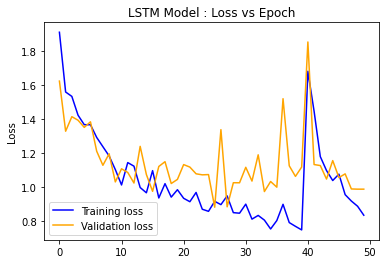

In [40]:
# loss visualization 

plt.plot(epoch_list, training_losses, label = "Training loss", color = "blue")
plt.plot(epoch_list, val_loss_list, label = "Validation loss", color = "orange")
plt.ylabel("Loss")
plt.title('LSTM Model : Loss vs Epoch')
plt.legend()

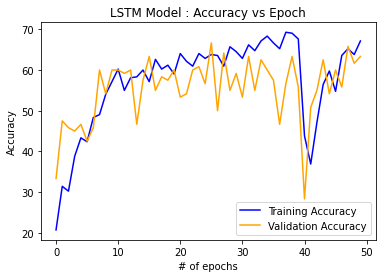

In [42]:
# visualization accuracy
plt.plot(epoch_list, training_acc, label = "Training Accuracy", color = "blue")
plt.plot(epoch_list, val_accuracy_list, label = "Validation Accuracy", color="orange")
plt.xlabel("# of epochs")
plt.ylabel("Accuracy")
plt.title("LSTM Model : Accuracy vs Epoch")
plt.legend()